This notebook report the code, output and written text summarizing the following tasks:
- Data Validation:   
  - Description of validation and cleaning steps 
- Exploratory Analysis:  
  - Creation of two different graphics showing single variables only to demonstrate the characteristics of data  
  - Creation of two different graphics showing two or more variables to represent the relationship between features
  - Description of main findings
- Model Development
  - Description of reasons for selecting the models and a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Description of the performance of the three different models based on an appropriate metric
- Business Metrics
  - Definition of the approach used to compare the model performance (KPI)
  - Description of models perform using this approach
- Final summary including recommendations that the business should undertake

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import os
import pandas as pd
import seaborn as sns
import yaml

from utils import *

from scipy import stats
from scipy.stats import boxcox, yeojohnson
from scipy.stats.mstats import winsorize
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from statsmodels.imputation import mice

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, precision_score

In [2]:
print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Users\tharc\Documents\GitHub\machine_learning\High_Traffic_Recipies


# 1. Steps in Data Cleaning
- Open CSV: Reads a CSV file named recipe_site_traffic_2212.csv into a DataFrame and checks its shape.
- Understand the Data: Displays the first five rows of the DataFrame for initial inspection.
- Summary Statistics: Generates descriptive statistics for the DataFrame to summarize the data.
- Value Count: Prints the count of unique values in each column of the DataFrame for exploratory analysis.
- Check Duplicates: Check the existence of duplicate rows in the Dataframe.
- Clean 'servings' column: Removes the string ' as a snack' from the 'servings' column.
- Clean 'category' column: Removes the string ' Breast' from 'Chicken Breast' since 'Chicken Breast' belongs to the category 'Chicken'.
- Map 'High Traffic': Converts the 'high_traffic' column from categorical to boolen (True for 'High', False otherwise).
- Missing Data Analysis: Calculates the missing values in the columns and prints them.
- Show Rows with Missing Values: Displays rows containing any missing values for review.
- Drop Rows with Missing Values: Drops rows with missing values because the missing are for the same rows and the total number of missing values is relatively small compared to the dataset size (5.49% of the total).
- Check Missing Values Again: Checks for any remaining missing values and prints those counts.
- Identify Data Types: Displays the data types of each column in the DataFrame.
- Data Type Conversion: Converts specified columns to appropriate data types (integers for servings; and category for category).
- Display Updated Data Types: Prints the DataFrame's data types after conversions to confirm changes.
- Save a copy of the dataframe to be used in the Exploratory Analysis to facilitate the interpretation.

In [3]:
# Load the config.yaml file
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

In [4]:
# List all the input data
data_base_folder = os.path.join(config["base_path"], r"Data")
_ = list_all_csv_in_folder(data_base_folder)

recipe_site_traffic_2212.csv


In [5]:
# Open CSV
df = pd.read_csv(r"data\\recipe_site_traffic_2212.csv", sep=",", encoding="utf-8")
df.shape

(947, 8)

In [6]:
# Understand the Data
df.head(5)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [7]:
# Understand the Data
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [8]:
# Understand the Data
# --> See all answers int he columns
for column in df.columns:
    print(f"Value counts for '{column}':")
    print(df[column].value_counts())
    print("\n")

Value counts for 'recipe':
1      1
637    1
625    1
626    1
627    1
      ..
320    1
321    1
322    1
323    1
947    1
Name: recipe, Length: 947, dtype: int64


Value counts for 'calories':
47.89     2
34.97     2
529.26    2
128.30    2
35.48     1
         ..
92.21     1
472.91    1
409.03    1
31.75     1
184.56    1
Name: calories, Length: 891, dtype: int64


Value counts for 'carbohydrate':
3.46     3
6.40     3
9.58     3
5.14     3
7.73     3
        ..
96.03    1
0.86     1
11.83    1
39.55    1
45.21    1
Name: carbohydrate, Length: 835, dtype: int64


Value counts for 'sugar':
1.62    5
1.51    5
2.97    4
1.27    4
0.77    4
       ..
5.44    1
1.80    1
2.00    1
9.00    1
6.20    1
Name: sugar, Length: 666, dtype: int64


Value counts for 'protein':
0.36      6
0.93      4
0.02      4
0.04      4
0.38      4
         ..
22.89     1
169.78    1
14.14     1
15.08     1
8.07      1
Name: protein, Length: 772, dtype: int64


Value counts for 'category':
Breakfast       

In [9]:
# Identify Duplicates
df.duplicated(subset='recipe').sum()

0

In [10]:
# Clean the 'servings' column
df['servings'] = df['servings'].str.replace(' as a snack', '', regex=False)
df['servings'].value_counts()

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

In [11]:
# Clean the 'category' Column
df['category'] = df['category'].str.replace(' Breast', '', regex=False)
df['category'].value_counts()

Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64

In [12]:
# Mapping 'high_traffic': True if 'High', otherwise False
df['high_traffic'] = df['high_traffic'].apply(lambda x: True if x == 'High' else False)
df['high_traffic'].value_counts()

True     574
False    373
Name: high_traffic, dtype: int64

In [13]:
# Check for Missing Values
missing_report = df.isnull().sum()
print(missing_report[missing_report > 0])

calories        52
carbohydrate    52
sugar           52
protein         52
dtype: int64


In [14]:
# Dealing missing data: 
# --> One rule of thumb is to remove observations if they amount to five percent or less of all values. 
perc_missing = df['calories'].isnull().sum() / df.shape[0]
perc_missing

0.054910242872228086

In [15]:
# Show the rows with missing
rows_with_missing = df[df.isnull().any(axis=1)]
rows_with_missing

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,True
23,24,NaN,NaN,NaN,NaN,Meat,2,False
48,49,NaN,NaN,NaN,NaN,Chicken,4,False
82,83,NaN,NaN,NaN,NaN,Meat,4,True
89,90,NaN,NaN,NaN,NaN,Pork,6,True
116,117,NaN,NaN,NaN,NaN,Chicken,6,True
121,122,NaN,NaN,NaN,NaN,Dessert,2,True
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,True
149,150,NaN,NaN,NaN,NaN,Potato,2,True
187,188,NaN,NaN,NaN,NaN,Pork,4,True


In [16]:
# Note above that the missing values are the same for these 4 columns 'calories', 'carbohydrate', 'sugar', 'protein'.
# --> Since the missing are for the same rows and the total number of missing values is relatively small compared to the dataset size (5.49% of the total), I choose to drop rows with missing values.
columns_with_missing = ['calories', 'carbohydrate', 'sugar', 'protein']
df = df.dropna(subset=columns_with_missing)

In [17]:
# Check for Missing Values again
df.isnull().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [18]:
# Identify the Data Type
df.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic       bool
dtype: object

In [19]:
# Data Type and Conversion
category_columns = ['category']
int_columns = ['servings']

# Change data types
for col in int_columns:
    df[col] = df[col].astype('int')

for col in category_columns:
    df[col] = df[col].astype('category')

# Display the updated DataFrame information
print(df.dtypes)

recipe             int64
calories         float64
carbohydrate     float64
sugar            float64
protein          float64
category        category
servings           int32
high_traffic        bool
dtype: object


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        895 non-null    int64   
 1   calories      895 non-null    float64 
 2   carbohydrate  895 non-null    float64 
 3   sugar         895 non-null    float64 
 4   protein       895 non-null    float64 
 5   category      895 non-null    category
 6   servings      895 non-null    int32   
 7   high_traffic  895 non-null    bool    
dtypes: bool(1), category(1), float64(4), int32(1), int64(1)
memory usage: 47.6 KB


In [21]:
# Save a copy to be used in the Exploratory Analysis to facilitate the interpretation
df_nolog = df.copy()

# Steps in Data Validation
- Plot distribution: Create box plots for all numerical columns to visualize the distribution, median, and potential outliers of each feature.
- Calculate Skewness: Computes the skewness for each numerical column in the DataFrame to assess the symmetry of their distributions.
- Interpret Skewness: Notes that a skewness value of 0 indicates a symmetrical distribution; features with high positive skewness (calories, carbohydrate, sugar, protein) are identified for further analysis.
- Calculate upper and lower boundaries: The function calculates the upper and lower boundaries for identifying outliers based on the Interquartile Range (IQR). Next, print these values.
- Yeo-Johnson Transformation: (After experimentation with diverse transformation methods) apply a Yeo-Johnson transformation to the identified positively skewed features (calories, carbohydrate, sugar, protein) to reduce skewness.
- Recalculate Skewness: Computes skewness again after transformation to evaluate the effectiveness of the logarithmic transformations.
- Generate Box Plots: Creates box plots for the numerical columns to visualize the distribution and potential outliers in the transformed dataset.
- Calculate Correlation Matrix: Computes the correlation matrix to understand the relationships between numerical features.
- Create Correlation Heatmap: Visualizes the correlation matrix as a heatmap to easily identify relationships and strengths among features.
- Final Correlation Check: Concludes there is no feature deletion necessary due to high correlation, as no correlation coefficient exceeds 0.7 among features.

In [22]:
# Generate Descriptive Statistics
# --> Note the high standard deviation, specially for the calories column.
# --> The quantile values indicate the presence of outliers.
df.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


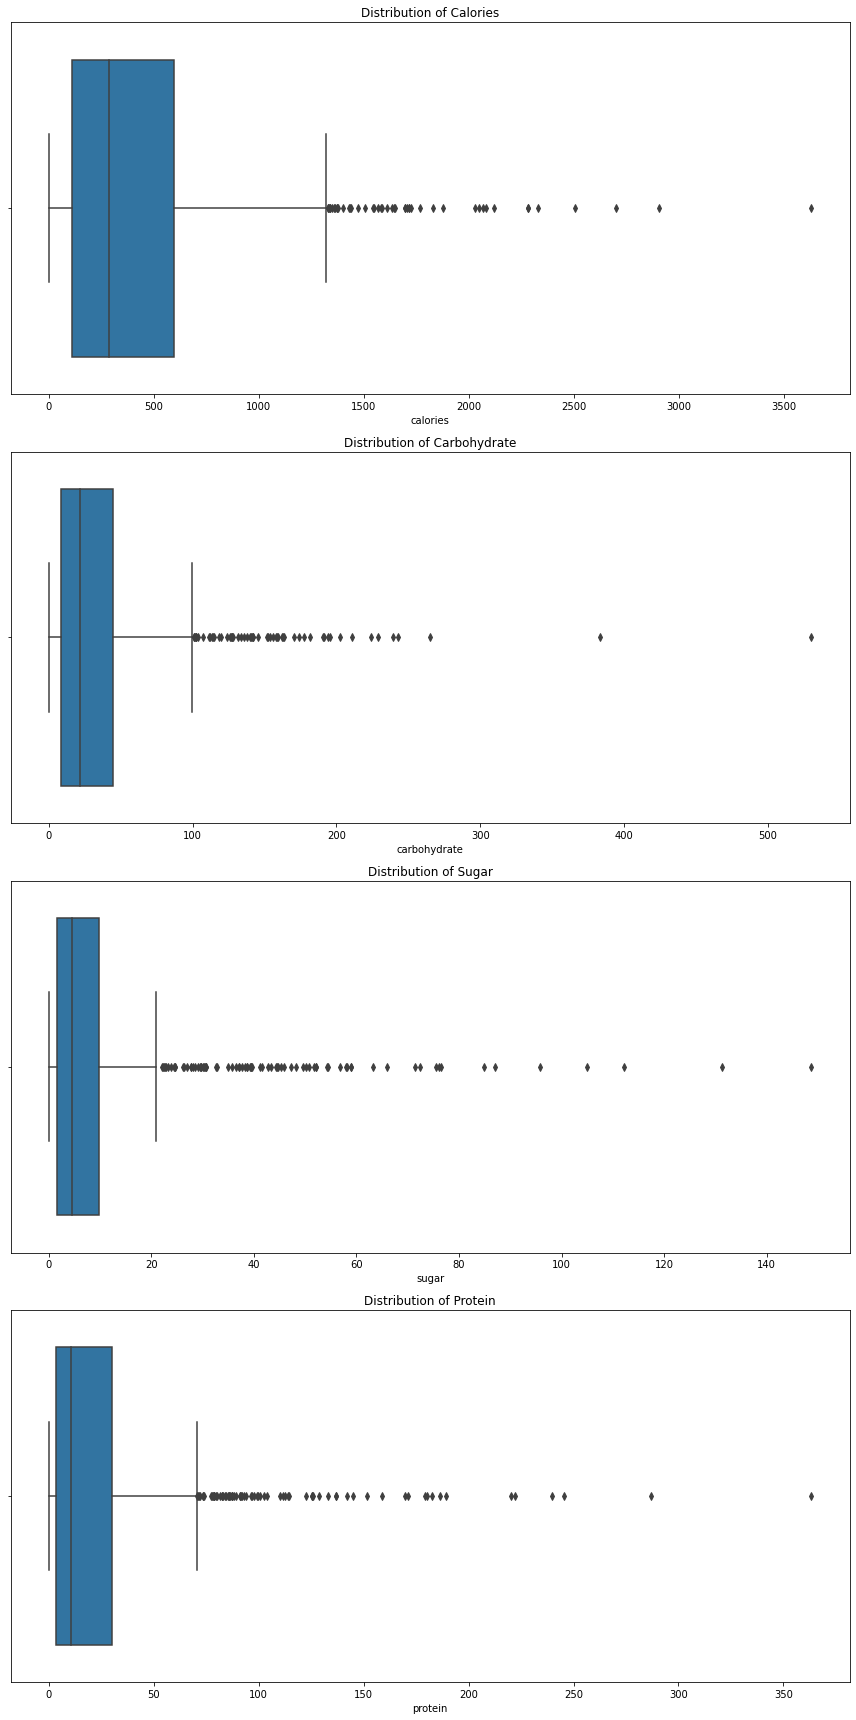

In [23]:
# Visualize the distributions of the numerical variables, showing their summary statistics and outliers.
# --> The plots below confirm the existence of outliers.
numerical_columns =  df.select_dtypes(include='float').columns

num_rows = len(numerical_columns)
fig, axes = plt.subplots(num_rows, 1, figsize=(12, 6 * num_rows))

for i, column in enumerate(numerical_columns):
    ax = axes[i] if num_rows > 1 else axes
    sns.boxplot(data=df, x=column, ax=ax)
    ax.set_title(f"Distribution of {column.capitalize()}")

plt.tight_layout()
plt.show()

In [24]:
# Calculate the skewness for each numerical column in the DataFrame
skewness = df.skew()
print("Skewness:\n", skewness)

Skewness:
 recipe         -0.008137
calories        2.036151
carbohydrate    3.756980
sugar           4.223352
protein         3.509453
servings        0.010145
high_traffic   -0.399428
dtype: float64


C:\Users\tharc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [25]:
# Interpretation of skewness
# --> A skewness value of 0 indicates a perfectly symmetrical distribution.
# --> Addressing skewness can lead to improved model interpretability and performance.
# --> Possible Actions: The features with high positive skewness (calories, carbohydrate, sugar, protein) require the deletion of outliers or the transformation to help normalize the distribution.

In [26]:
# Dealing with Outliers
# --> The plots above confirm the existence of outliers.

# Function to calculate upper and lower boundaries of columns
def calculate_outlier_limits(data, factor=1.5):
    # Find 25% and 75% percentiles
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    
    #calculate IQR
    iqr = q3 - q1
    
    #calculate lower and upper boundaries
    lower_limit = q1 - (factor * iqr)
    upper_limit = q3 + (factor * iqr)
    return lower_limit, upper_limit

In [27]:
# Dealing with Outliers
# --> Calculate outlier limits for each numerical column

positively_skewed_features = ['calories', 'carbohydrate', 'sugar', 'protein']

outlier_limits = {}
for column in positively_skewed_features:
    lower_limit, upper_limit = calculate_outlier_limits(df[column])
    outlier_limits[column] = (lower_limit, upper_limit)

for column, limits in outlier_limits.items():
    print(f"Column: {column}")
    print(f"Lower Limit: {limits[0]}")
    print(f"Upper Limit: {limits[1]}")
    print("--------------------------------")

Column: calories
Lower Limit: -620.3999999999999
Upper Limit: 1328.48
--------------------------------
Column: carbohydrate
Lower Limit: -46.510000000000005
Upper Limit: 99.85000000000001
--------------------------------
Column: sugar
Lower Limit: -10.475000000000003
Upper Limit: 21.965000000000003
--------------------------------
Column: protein
Lower Limit: -37.31250000000001
Upper Limit: 70.70750000000001
--------------------------------


In [28]:
# Dealing with Outliers
# -->  After many experimentation to address the positively skewed features, I identified that the Yeo-Johnson Transformation is the most effective approach.
positively_skewed_features = ['calories', 'carbohydrate', 'sugar', 'protein']

for column, limits in outlier_limits.items():
    lower_limit, upper_limit = limits
    
    #df = df[df[column] <= upper_limit]                         # Removing Outliers
    #df[column] = df[column].clip(upper=upper_limit)            # Capping Outliers
    #df[column] = winsorize(df[column], limits=[0.05, 0.05])    # Winsorization
    #df[column] = np.log1p(df[column])                          # Logarithmic Transformation
    #df[column] = np.sqrt(df[column])                           # Square Root Transformation

    df[column] = yeojohnson(df[column])[0]                      # Yeo-Johnson Transformation

df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,5.742713,4.409023,0.481476,0.653469,Potato,4,True
2,3,17.437755,4.550612,1.224094,1.360783,Breakfast,1,False
3,4,8.416476,4.091120,2.587147,0.019804,Beverages,4,True
4,5,5.133412,1.101661,0.553884,0.425754,Beverages,4,False
5,6,16.024490,1.607528,0.883720,4.049462,One Dish Meal,2,True


In [29]:
# Calculate skewness again
# --> Note that the skewness decreased strongly.
skewness = df.skew()
print("Skewness:\n", skewness)

Skewness:
 recipe         -0.008137
calories       -0.044536
carbohydrate   -0.013172
sugar           0.041324
protein        -0.001911
servings        0.010145
high_traffic   -0.399428
dtype: float64


C:\Users\tharc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
# Box plots
# num_columns = ['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'high_traffic']

# for i, column in enumerate(num_columns):
#     plt.subplot(3, 3, i + 1)  
#     sns.boxplot(data=df, y=column, color='skyblue')
#     plt.title(f'Box Plot of {column}')
#     plt.ylabel(column)

# plt.tight_layout() 
# plt.show()

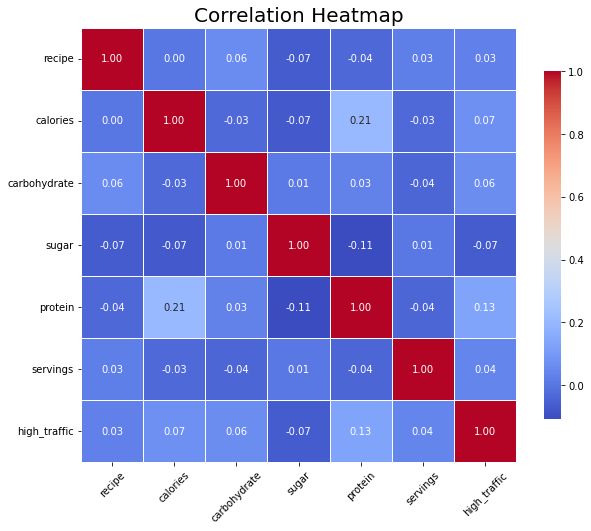

In [31]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [32]:
# No feature delection due to high correlation since no features are highly correlated (0.7 or more)

# 2. Exploratory Analysis

Graph 1: Histogram for the 'Calories' Variable
- Description: This histogram shows the distribution of calorie counts across recipes.
- Interpretation: The distribution might reveal the most common caloric range for recipes, helping in understanding dietary preferences.
- Finding: The most of the recipies (around 780) have no more than 750 calories.

Graph 2: Bar Plot for the 'Category' Variable
- Description: This bar plot represents the count of recipes available in each category.
- Interpretation: It provides insights into which categories have more recipes, indicating potential popularity or diversity in offerings.
- Finding: Note that the popularity is similar. The number of recipies for each category ranges between (around) 70 and 110.

Graph 3: Scatter Plot of Calories vs. Protein
- Description: This scatter plot illustrates the relationship between calorie content and protein levels in recipes, differentiated by category.
- Interpretation: This visual aids in understanding how calorie density correlates with protein content across different recipe categories.
- Finding: Note that the most of the recipies are found in the bottom left of the plot indicating they have low levels of proteins and calories.

Graph 4: Count of High Traffic Recipes by Category
- Description: The graph illustrates the number of recipes in various categories, with a distinction between those classified as "High" traffic and those that are not.
- Interpretation: The analysis reveals that specific categories attract more high traffic.
- Finding: Note that certain categories, such as Vegetable, Potato, and Pork, have a significantly higher number of "High" traffic recipes compared to others.

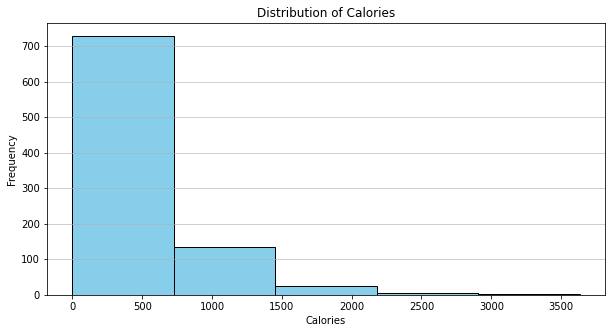

In [33]:
# 1. Histogram for the 'calories' variable
plt.figure(figsize=(10, 5))
plt.hist(df_nolog['calories'], bins=5, color='skyblue', edgecolor='black')
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

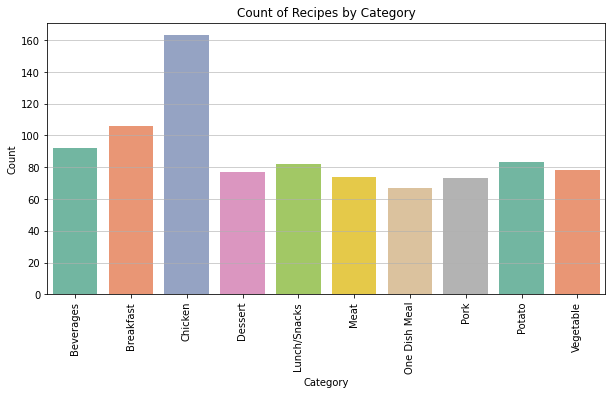

In [34]:
# 2. Bar Plot for the 'category' variable
plt.figure(figsize=(10, 5))
sns.countplot(data=df_nolog, x='category', palette='Set2')
plt.title('Count of Recipes by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.grid(axis='y', alpha=0.75)
plt.show()

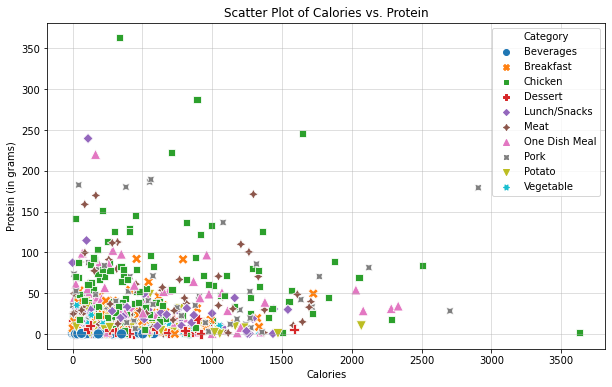

In [35]:
# 3. Scatter plot to create a grouped bar plot showing the average calories per category.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_nolog, x='calories', y='protein', hue='category', style='category', s=100)
plt.title('Scatter Plot of Calories vs. Protein')
plt.xlabel('Calories')
plt.ylabel('Protein (in grams)')
plt.grid(alpha=0.5)
plt.legend(title='Category')
plt.show()

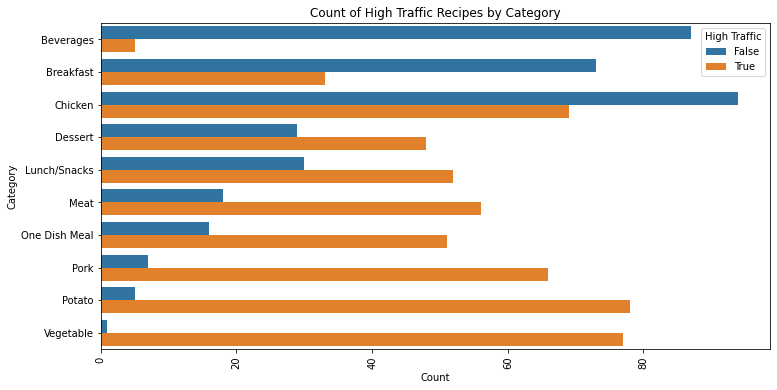

In [36]:
# 4. Count of recipes categorized by their category and whether they are classified as "High" traffic or not.
plt.figure(figsize=(12, 6))
sns.countplot(y="category", hue="high_traffic", data=df_nolog)
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Count of High Traffic Recipes by Category")
plt.xticks(rotation=90)
plt.legend(title="High Traffic")
plt.show()

In [37]:
del df_nolog # Dataframe used only for Explanatory Analysis

# 3. Model Depelopment: Steps applied

1. One-Hot Encoding
- One-hot encoding to the 'category' variable. 
- The categorical values are turned into binary columns, which allows the model to interpret these variables numerically.

2. Splitting the Data
- The dataset is split into features (X) and a target variable (y). 

3. K-Fold Cross-Validation
- K-Fold Cross-Validation is then applied to assess the model's performance before the data is split into training and testing sets.

4. Training and Testing Split
- The dataset is further divided into training and testing sets using an 80-20 split. 

5. Hyperparameter Tuning
- In order to improve the performance of the models, hyperparameter tuning is carried out for each of the selected algorithms: Logistic Regression, Random Forest, and Gradient Boosting. 
- Specific hyperparameter grids are defined for each model, detailing various parameters to be tested. 

6. Model Fitting with Tuning
- Using GridSearchCV, each model is fitted to the training data while exploring the combinations of hyperparameters defined in the previous step. 
- This process involves performing cross-validation to assess which combinations yield the best results based on the F1 score.

7. Retrieving Best Parameters
- After completing the fitting process, the best hyperparameters for each model are identified based on their performance during cross-validation. 
- The best parameters and average F1 scores are printed for all models.

8. Fitting Tuned Models
- The best-performing models, as identified through hyperparameter tuning, are retrained on the entire training dataset.

9. Making Predictions
- Using the tuned models, predictions are generated for the test dataset.
- Each model provides a set of predictions that can be compared against the actual target values to evaluate performance.

10. Model Evaluation
- The performance of each model is then evaluated by calculating the F1 score and accuracy.

In [38]:
# Perform one-hot encoding on the 'category' variable
df = pd.get_dummies(df, columns=['category'], prefix='cat')
df.columns

Index(['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'servings',
       'high_traffic', 'cat_Beverages', 'cat_Breakfast', 'cat_Chicken',
       'cat_Dessert', 'cat_Lunch/Snacks', 'cat_Meat', 'cat_One Dish Meal',
       'cat_Pork', 'cat_Potato', 'cat_Vegetable'],
      dtype='object')

In [39]:
df.head(5)

,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic,cat_Beverages,cat_Breakfast,cat_Chicken,cat_Dessert,cat_Lunch/Snacks,cat_Meat,cat_One Dish Meal,cat_Pork,cat_Potato,cat_Vegetable
1,2,5.742713,4.409023,0.481476,0.653469,4,True,0,0,0,0,0,0,0,0,1,0
2,3,17.437755,4.550612,1.224094,1.360783,1,False,0,1,0,0,0,0,0,0,0,0
3,4,8.416476,4.091120,2.587147,0.019804,4,True,1,0,0,0,0,0,0,0,0,0
4,5,5.133412,1.101661,0.553884,0.425754,4,False,1,0,0,0,0,0,0,0,0,0
5,6,16.024490,1.607528,0.883720,4.049462,2,True,0,0,0,0,0,0,1,0,0,0


In [40]:
# Splitting the data into features (X) and target (y)
X = df.drop(['high_traffic'], axis=1)
y = df['high_traffic']

In [41]:
# Using K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression()
scores = cross_val_score(model, X, y, cv=kf, scoring='f1')

print("F1 Scores for each fold:", scores)
print("Mean F1 Score:", scores.mean())
print("Standard Deviation of F1 Score:", scores.std())

C:\Users\tharc\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\tharc\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

F1 Scores for each fold: [0.81278539 0.79262673 0.77828054 0.81339713 0.8       ]
Mean F1 Score: 0.7994179576822962
Standard Deviation of F1 Score: 0.01317084131742504


C:\Users\tharc\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [42]:
# Intepretating the outputs of k-Fold Cross-Validation
# --> A mean F1 score of approximately 0.8 suggests that the model performs well in terms of balancing precision and recall across different subsets of the data.
# --> A low standard deviation (0.02) indicates that the model's performance is relatively consistent across the different subsets of data used in cross-validation.
# --> Consequently, the model is likely to generalize well to unseen data.

In [43]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Tuning hyperparameters to improve the performance of the models.

# Hyperparameters for Logistic Regression
logistic_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# Hyperparameters for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Hyperparameters for Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

In [45]:
# Instantiate the Models for Grid Search
# Logistic Regression
logistic_grid_search = GridSearchCV(LogisticRegression(max_iter=1000), logistic_param_grid, cv=5, scoring='f1')
# Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='f1')
# Gradient Boosting
gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=5, scoring='f1')

In [46]:
# Fit the Models with Hyperparameter Tuning using GridSearchCV
logistic_grid_search.fit(X_train, y_train)
rf_grid_search.fit(X_train, y_train)
gb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [47]:
# Retrieve and Display the Best Parameters and Scores
# --> For each model, the best combination of hyperparameters is identified based on the average F1 score from cross-validation.

# Logistic Regression
print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)
print("Best F1 Score for Logistic Regression:", logistic_grid_search.best_score_)

# Random Forest
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best F1 Score for Random Forest:", rf_grid_search.best_score_)

# Gradient Boosting
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)
print("Best F1 Score for Gradient Boosting:", gb_grid_search.best_score_)

Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Best F1 Score for Logistic Regression: 0.8150312129218322
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Best F1 Score for Random Forest: 0.8047462048337379
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best F1 Score for Gradient Boosting: 0.8128189988750082


In [48]:
# Fitting Tuned Models and Making Predictions

# Retrieve the best models
best_logistic_model = logistic_grid_search.best_estimator_
best_rf_model = rf_grid_search.best_estimator_
best_gb_model = gb_grid_search.best_estimator_

# Fit the best models on the training data
best_logistic_model.fit(X_train, y_train)
best_rf_model.fit(X_train, y_train)
best_gb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, random_state=42)

In [49]:
# Make Predictions Using the Tuned Models
logistic_preds_tuned = best_logistic_model.predict(X_test)
rf_preds_tuned = best_rf_model.predict(X_test)
gb_preds_tuned = best_gb_model.predict(X_test)

# 4. Model Evaluation
- Object: We want to predict which recipes will be popular 80% of the time and minimize the chance of showing unpopular recipes.
- Strategy: Defined a KPI to compare model performance to business criteria in the problem.
- *Course: Supervised Learning with scikit-learn*

- Choice: The KPI used to compare the models will be the *Precision*.
- Precision indicates the proportion of positive identifications that were actually correct. If the precision for high-traffic predictions is 80% or above, this supports the goal.

In [50]:
# Showing Confusion Matrix
# --> Given a binary classifier, such as our "recipe is popular" case, we can create a 2-by-2 matrix that summarizes performance called a confusion matrix. 
print("\nLogistic Regression Report:")
print(classification_report(y_test, logistic_preds_tuned))
print("Random Forest Report:")
print(classification_report(y_test, rf_preds_tuned))
print("Gradient Boosting Report:")
print(classification_report(y_test, gb_preds_tuned))


Logistic Regression Report:
              precision    recall  f1-score   support

       False       0.72      0.45      0.55        73
        True       0.70      0.88      0.78       106

    accuracy                           0.70       179
   macro avg       0.71      0.66      0.67       179
weighted avg       0.71      0.70      0.69       179

Random Forest Report:
              precision    recall  f1-score   support

       False       0.77      0.51      0.61        73
        True       0.73      0.90      0.80       106

    accuracy                           0.74       179
   macro avg       0.75      0.70      0.71       179
weighted avg       0.74      0.74      0.72       179

Gradient Boosting Report:
              precision    recall  f1-score   support

       False       0.70      0.29      0.41        73
        True       0.65      0.92      0.76       106

    accuracy                           0.66       179
   macro avg       0.68      0.60      0.58       1

In [51]:
# Evaluate the Model Performance using (only) Precision as KPI
logistic_precision = precision_score(y_test, logistic_preds_tuned)
rf_precision = precision_score(y_test, rf_preds_tuned)
gb_precision = precision_score(y_test, gb_preds_tuned)

print(f"Precision of the (tuned) Logistic Regression: {logistic_precision}")
print(f"Precision of the (tuned) Random Forest: {rf_precision}")
print(f"Precision of the (tuned) Gradient Boosting: {gb_precision}")

Precision of the (tuned) Logistic Regression: 0.6992481203007519
Precision of the (tuned) Random Forest: 0.7251908396946565
Precision of the (tuned) Gradient Boosting: 0.6510067114093959


# 5. Business Recommendations
Given the evaluation results, the following business recommendations are proposed:

- Prioritize Random Forest for High Traffic Predictions.
- This model has the highest precision among the three.
- 73% of the recipes predicted as high traffic were indeed high traffic. 
- While this is a decent precision score, it falls short of the desired target of 80%.